- Denoising Feature Matching
- not implemented std annealing

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input, Reshape, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
def ConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2D(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation(leakyrelu)(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

def deConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2DTranspose(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation('relu')(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

In [4]:
class DFM(keras.Model):
    def __init__(self, x_dim, z_dim): # dim: tuple
        super(DFM, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim

        self.generator = self.build_generator()
        self.discriminator, self.denoiser = self.build_discriminator()
        
        self.adv_w = 0.03
        self.denoise_w = 1
        
    def compile(self, g_optim, d_optim, de_optim, loss_fn):
        super(DFM, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.de_optim = de_optim
        self.loss_fn = loss_fn
        
    def build_generator(self): 
        inputs = Input(shape = self.z_dim)
        
        x = Dense(128*7*7, activation='relu')(inputs)
        x = Reshape((7, 7, 128))(x) # 7, ,7 128
        x = BatchNormalization(momentum=0.8)(x)
        x = deConvBlock(64)(x) # 14, 14, 64
        x = deConvBlock(32)(x) # 28, 28, 32
        
        outputs = Conv2D(1, kernel_size=3, strides=1, activation='tanh', padding='same')(x) # 28, 28, 1
        return Model(inputs, outputs, name='generator')

    def build_discriminator(self):
        inputs = Input(shape = self.x_dim)
        
        h = ConvBlock(16)(inputs)
        h = ConvBlock(32)(h)
        f = ConvBlock(64)(h)
        
        f = Flatten()(f)
        outputs = Dense(1)(f)
        
        d = deConvBlock(32)(h)
        d = deConvBlock(16)(d)
        d = Conv2D(1, kernel_size=3, strides=1, activation='tanh', padding='same')(d)
        return Model(inputs, outputs, name='discriminator'), Model(inputs, d, name='denoising')
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        
        noise = tf.random.normal((batch_size, self.z_dim))
        
        # discriminator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            all_x = tf.concat([x, fake], 0)
            preds = self.discriminator(all_x)
            
            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            preds = self.discriminator(fake)
            denoised = self.denoiser(x)

            g_adv_loss =  self.adv_w * self.loss_fn(real_labels, preds)
            g_denoised_loss =  self.denoise_w * losses.MeanSquaredError()(denoised, fake)
            g_loss = g_adv_loss + g_denoised_loss
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        
        with tf.GradientTape() as tape:
            corrupted = x + tf.random.truncated_normal(tf.shape(x), 0, 0.5)
            recon = self.denoiser(corrupted)
            
            de_loss = losses.MeanSquaredError()(x, recon)

        grads = tape.gradient(de_loss, self.denoiser.trainable_weights)
        self.de_optim.apply_gradients(zip(grads, self.denoiser.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}

In [5]:
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            r, c = 2, 5
            noise = np.random.normal(0, 1, (r*c, 100))
            imgs = self.model.generator.predict(noise)*0.5 +0.5
            imgs = imgs.reshape(r*c, 28, 28)
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(imgs[n], cmap='gray')
                    axs[i,j].axis('off')
                    n += 1
            plt.show()
            plt.close()

In [6]:
# prepare data
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = np.expand_dims(train_X, -1)


In [7]:
shape = train_X.shape[1:]
gan = DFM(shape, 100)

In [8]:
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.BinaryCrossentropy(from_logits=True), 
         )

Epoch 1/101
469/469 [==============================] - ETA: 0s - d_loss: 0.3210 - g_loss: 0.2848

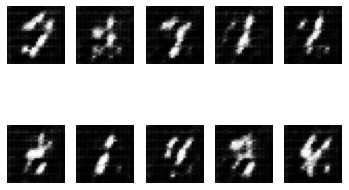

469/469 [==============================] - 13s 29ms/step - d_loss: 0.3209 - g_loss: 0.2851
Epoch 2/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.3456 - g_loss: 0.4458
Epoch 3/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.3808 - g_loss: 0.4691
Epoch 4/101
469/469 [==============================] - 12s 27ms/step - d_loss: 0.3922 - g_loss: 0.4767
Epoch 5/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.3955 - g_loss: 0.4778
Epoch 6/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.3960 - g_loss: 0.4801
Epoch 7/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.4005 - g_loss: 0.4824
Epoch 8/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.3977 - g_loss: 0.4813
Epoch 9/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.4029 - g_loss: 0.4819
Epoch 10/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.412

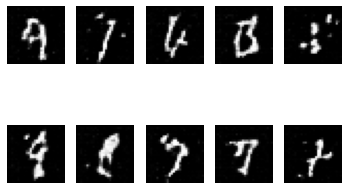

469/469 [==============================] - 13s 28ms/step - d_loss: 0.4118 - g_loss: 0.4821
Epoch 12/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4126 - g_loss: 0.4829
Epoch 13/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4121 - g_loss: 0.4829
Epoch 14/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4125 - g_loss: 0.4826
Epoch 15/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4163 - g_loss: 0.4827
Epoch 16/101
469/469 [==============================] - 12s 27ms/step - d_loss: 0.4165 - g_loss: 0.4834
Epoch 17/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4168 - g_loss: 0.4834
Epoch 18/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4175 - g_loss: 0.4838
Epoch 19/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4167 - g_loss: 0.4839
Epoch 20/101
469/469 [==============================] - 13s 27ms/step - d_los

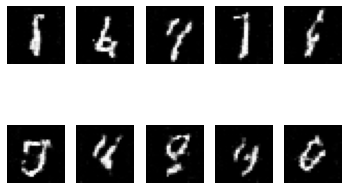

469/469 [==============================] - 13s 28ms/step - d_loss: 0.4228 - g_loss: 0.4844
Epoch 22/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4215 - g_loss: 0.4846
Epoch 23/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4211 - g_loss: 0.4849
Epoch 24/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4233 - g_loss: 0.4851
Epoch 25/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4193 - g_loss: 0.4847
Epoch 26/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4248 - g_loss: 0.4853
Epoch 27/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4198 - g_loss: 0.4853
Epoch 28/101
469/469 [==============================] - 12s 27ms/step - d_loss: 0.4201 - g_loss: 0.4856
Epoch 29/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4208 - g_loss: 0.4854
Epoch 30/101
469/469 [==============================] - 13s 27ms/step - d_los

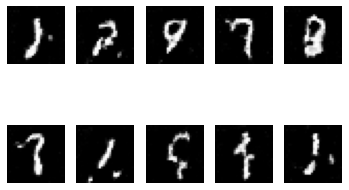

469/469 [==============================] - 13s 28ms/step - d_loss: 0.4215 - g_loss: 0.4863
Epoch 32/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4228 - g_loss: 0.4867
Epoch 33/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4210 - g_loss: 0.4860
Epoch 34/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4231 - g_loss: 0.4868
Epoch 35/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4234 - g_loss: 0.4871
Epoch 36/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4286 - g_loss: 0.4872
Epoch 37/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4223 - g_loss: 0.4872
Epoch 38/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4283 - g_loss: 0.4877
Epoch 39/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4266 - g_loss: 0.4875
Epoch 40/101
469/469 [==============================] - 13s 27ms/step - d_los

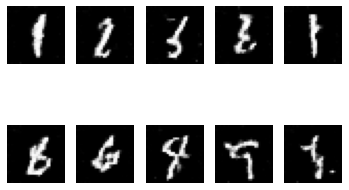

469/469 [==============================] - 13s 28ms/step - d_loss: 0.4245 - g_loss: 0.4879
Epoch 42/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4285 - g_loss: 0.4880
Epoch 43/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4324 - g_loss: 0.4888
Epoch 44/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4278 - g_loss: 0.4886
Epoch 45/101
469/469 [==============================] - 12s 27ms/step - d_loss: 0.4279 - g_loss: 0.4883
Epoch 46/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4300 - g_loss: 0.4886
Epoch 47/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4305 - g_loss: 0.4885
Epoch 48/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4310 - g_loss: 0.4890
Epoch 49/101
469/469 [==============================] - 12s 27ms/step - d_loss: 0.4313 - g_loss: 0.4887
Epoch 50/101
469/469 [==============================] - 12s 27ms/step - d_los

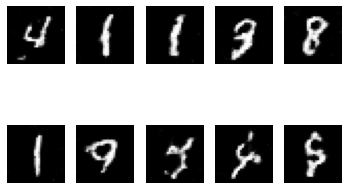

469/469 [==============================] - 13s 28ms/step - d_loss: 0.4288 - g_loss: 0.4895
Epoch 52/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4313 - g_loss: 0.4894
Epoch 53/101
469/469 [==============================] - 12s 27ms/step - d_loss: 0.4297 - g_loss: 0.4890
Epoch 54/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4308 - g_loss: 0.4895
Epoch 55/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.4276 - g_loss: 0.4890
Epoch 56/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4317 - g_loss: 0.4901
Epoch 57/101
469/469 [==============================] - 12s 27ms/step - d_loss: 0.4293 - g_loss: 0.4897
Epoch 58/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4344 - g_loss: 0.4900
Epoch 59/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4285 - g_loss: 0.4892
Epoch 60/101
469/469 [==============================] - 13s 27ms/step - d_los

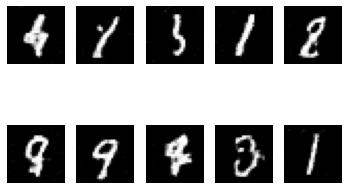

469/469 [==============================] - 14s 29ms/step - d_loss: 0.4321 - g_loss: 0.4900
Epoch 62/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.4308 - g_loss: 0.4897
Epoch 63/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.4296 - g_loss: 0.4905
Epoch 64/101
469/469 [==============================] - 12s 27ms/step - d_loss: 0.4296 - g_loss: 0.4900
Epoch 65/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4293 - g_loss: 0.4896
Epoch 66/101
469/469 [==============================] - 14s 29ms/step - d_loss: 0.4295 - g_loss: 0.4907
Epoch 67/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.4307 - g_loss: 0.4902
Epoch 68/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.4294 - g_loss: 0.4899
Epoch 69/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.4311 - g_loss: 0.4906
Epoch 70/101
469/469 [==============================] - 13s 28ms/step - d_los

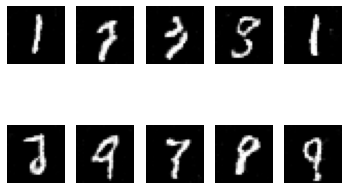

469/469 [==============================] - 15s 32ms/step - d_loss: 0.4293 - g_loss: 0.4904
Epoch 72/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.4309 - g_loss: 0.4911
Epoch 73/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.4305 - g_loss: 0.4906
Epoch 74/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4281 - g_loss: 0.4906
Epoch 75/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.4301 - g_loss: 0.4902
Epoch 76/101
469/469 [==============================] - 13s 28ms/step - d_loss: 0.4309 - g_loss: 0.4904
Epoch 77/101
469/469 [==============================] - 12s 27ms/step - d_loss: 0.4299 - g_loss: 0.4907
Epoch 78/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4295 - g_loss: 0.4910
Epoch 79/101
469/469 [==============================] - 12s 27ms/step - d_loss: 0.4291 - g_loss: 0.4905
Epoch 80/101
469/469 [==============================] - 12s 26ms/step - d_los

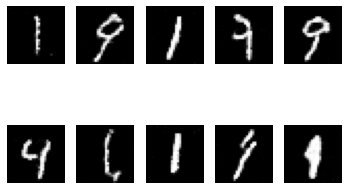

469/469 [==============================] - 13s 27ms/step - d_loss: 0.4267 - g_loss: 0.4917
Epoch 82/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4276 - g_loss: 0.4908
Epoch 83/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4298 - g_loss: 0.4909
Epoch 84/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4270 - g_loss: 0.4910
Epoch 85/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4281 - g_loss: 0.4910
Epoch 86/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4271 - g_loss: 0.4911
Epoch 87/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4280 - g_loss: 0.4914
Epoch 88/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4273 - g_loss: 0.4910
Epoch 89/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4284 - g_loss: 0.4913
Epoch 90/101
469/469 [==============================] - 12s 26ms/step - d_los

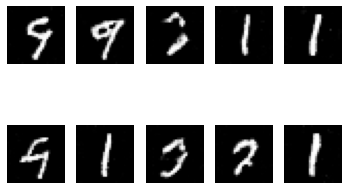

469/469 [==============================] - 13s 27ms/step - d_loss: 0.4249 - g_loss: 0.4913
Epoch 92/101
469/469 [==============================] - 12s 27ms/step - d_loss: 0.4281 - g_loss: 0.4908
Epoch 93/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4281 - g_loss: 0.4913
Epoch 94/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4285 - g_loss: 0.4909
Epoch 95/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4264 - g_loss: 0.4908
Epoch 96/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4281 - g_loss: 0.4914
Epoch 97/101
469/469 [==============================] - 12s 26ms/step - d_loss: 0.4240 - g_loss: 0.4910
Epoch 98/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4288 - g_loss: 0.4919
Epoch 99/101
469/469 [==============================] - 13s 27ms/step - d_loss: 0.4250 - g_loss: 0.4913
Epoch 100/101
469/469 [==============================] - 13s 28ms/step - d_lo

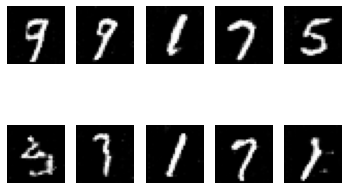

469/469 [==============================] - 13s 28ms/step - d_loss: 0.4274 - g_loss: 0.4913


In [9]:
gan.fit(train_X,
       epochs=101,
       shuffle=True,
       callbacks=[PlotCallback()],
       batch_size=128)